<a href="https://colab.research.google.com/github/Tousif-Rehman/EDA_Assignment/blob/main/Tousif_Rehman_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge datasets
merged = pd.merge(transactions, customers, on='CustomerID')
final_data = pd.merge(merged, products, on='ProductID')

In [35]:
# 1. Total spending per customer
total_spending = final_data.groupby('CustomerID')['TotalValue'].sum().reset_index(name='TotalSpending')

# 2. Average transaction value
avg_transaction = final_data.groupby('CustomerID')['TotalValue'].mean().reset_index(name='AvgTransactionValue')

# 3. Number of transactions
transaction_count = final_data.groupby('CustomerID')['TransactionID'].count().reset_index(name='TransactionCount')

# 4. Product category preferences (percentage per category)
category_pivot = pd.pivot_table(
    final_data,
    index='CustomerID',
    columns='Category',
    values='TransactionID',
    aggfunc='count',
    fill_value=0
)
category_percent = category_pivot.div(category_pivot.sum(axis=1), axis=0)

# 5. Region (one-hot encoding)
region_encoded = pd.get_dummies(customers[['CustomerID', 'Region']], columns=['Region'])

# 6. Time since signup (days from SignupDate to last TransactionDate)
final_data['SignupDate'] = pd.to_datetime(final_data['SignupDate'])
final_data['TransactionDate'] = pd.to_datetime(final_data['TransactionDate'])
last_transaction = final_data.groupby('CustomerID')['TransactionDate'].max().reset_index()
customer_features = pd.merge(customers, last_transaction, on='CustomerID')
customer_features['SignupDate'] = pd.to_datetime(customer_features['SignupDate'])  # Ensure correct type
customer_features['TimeSinceSignup'] = (customer_features['TransactionDate'] - customer_features['SignupDate']).dt.days
time_since_signup = customer_features[['CustomerID', 'TimeSinceSignup']]

# Combine all features
features = pd.merge(total_spending, avg_transaction, on='CustomerID')
features = pd.merge(features, transaction_count, on='CustomerID')
features = pd.merge(features, region_encoded, on='CustomerID')
features = pd.merge(features, category_percent.reset_index(), on='CustomerID')
features = pd.merge(features, time_since_signup, on='CustomerID')

# Set CustomerID as index
features.set_index('CustomerID', inplace=True)


In [36]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

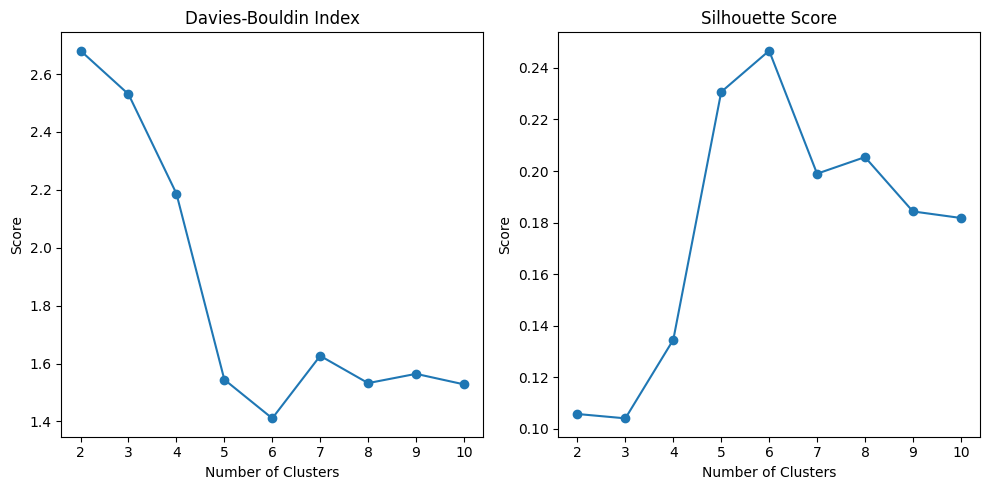

In [37]:
db_scores = []
silhouette_scores = []
cluster_range = range(2, 11)  # 2 to 10 clusters

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)

    # Calculate metrics
    db_scores.append(davies_bouldin_score(features_scaled, cluster_labels))
    silhouette_scores.append(silhouette_score(features_scaled, cluster_labels))

# Plot metrics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

In [38]:
# Apply K-Means with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Add cluster labels to features
features['Cluster'] = clusters

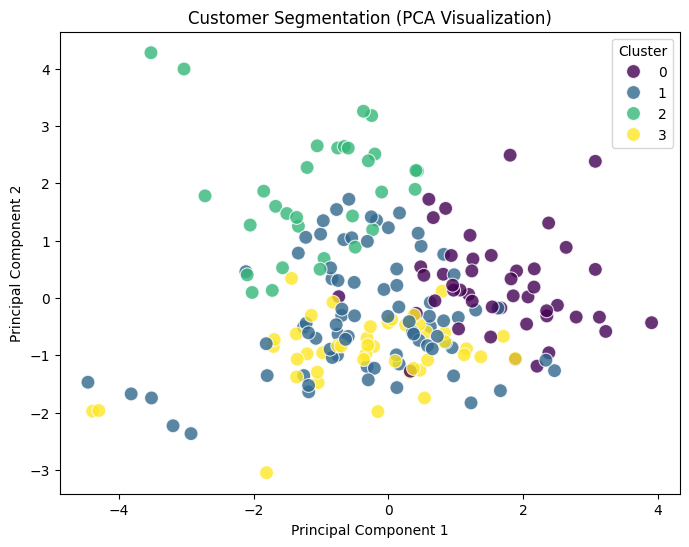

In [39]:
# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=features_pca[:, 0],
    y=features_pca[:, 1],
    hue=features['Cluster'],
    palette='viridis',
    s=100,
    alpha=0.8
)
plt.title('Customer Segmentation (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [40]:
# Final metrics
print(f"Davies-Bouldin Index: {db_scores[2]:.3f}")  # For 4 clusters (index 2 in the list)
print(f"Silhouette Score: {silhouette_scores[2]:.3f}")
print(f"Number of Clusters: 4")

Davies-Bouldin Index: 2.187
Silhouette Score: 0.135
Number of Clusters: 4
